In [18]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPooling2D, \
                                    UpSampling2D, Input, Flatten, Reshape, InputLayer
import matplotlib.pyplot as plt
import numpy as np

In [13]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
latent_dimension = 256

### Define encoder

In [5]:
encoder = tf.keras.Sequential([
    InputLayer(input_shape=(28, 28, 1)),
    Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
    Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
    Flatten(),
    Dense(latent_dimension),
], name='encoder')

### Define decoder

In [6]:
decoder = tf.keras.Sequential([
    InputLayer(input_shape=(latent_dimension,)),
    Dense(units=7*7*32, activation='relu'),
    Reshape(target_shape=(7, 7, 32)),
    Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding='SAME', activation='relu'),
    Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding='SAME', activation='relu'),
    Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding='SAME')
], name='decoder')

### Combine encoder and decoder into autoencoder

In [8]:
inp = Input((28, 28, 1))
output1 = encoder(inp)
output2 = decoder(output1)

auto_encoder = tf.keras.Model(inp, output2)

## Train autoencoder

In [15]:
auto_encoder.compile(loss=tf.keras.losses.MSE, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [28]:
auto_encoder.fit(X_train, X_train, batch_size=128, epochs=100, verbose=1)

Train on 60000 samples
Epoch 1/100
60000/60000 [==============================] - 27s 452us/sample - loss: 32.4131 - accuracy: 0.6436
Epoch 2/100
60000/60000 [==============================] - 27s 444us/sample - loss: 31.4370 - accuracy: 0.6506
Epoch 3/100
60000/60000 [==============================] - 27s 448us/sample - loss: 29.9942 - accuracy: 0.6492
Epoch 4/100
60000/60000 [==============================] - 29s 485us/sample - loss: 28.9115 - accuracy: 0.6527
Epoch 5/100
60000/60000 [==============================] - 29s 477us/sample - loss: 27.5460 - accuracy: 0.6510
Epoch 6/100
60000/60000 [==============================] - 29s 475us/sample - loss: 26.9297 - accuracy: 0.6548
Epoch 7/100
60000/60000 [==============================] - 31s 514us/sample - loss: 25.5789 - accuracy: 0.6594
Epoch 8/100
60000/60000 [==============================] - 28s 473us/sample - loss: 25.0577 - accuracy: 0.6632
Epoch 9/100
60000/60000 [==============================] - 28s 459us/sample - loss: 24.32

KeyboardInterrupt: 

## Visualize result

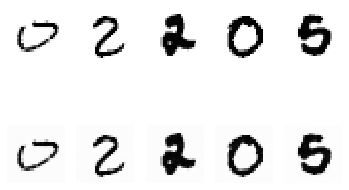

In [29]:
choice = np.random.choice(X_test.shape[0], 5, replace=False)
x = X_test[choice]
x_pred = auto_encoder.predict(x)

fig, ax = plt.subplots(2, 5, squeeze=False)

for i in range(x.shape[0]):
    ax[0][i].imshow(x[i].reshape((28, 28)), cmap='Greys')
    ax[1][i].imshow(x_pred[i].reshape(28, 28), cmap='Greys')
    ax[0][i].axis('off')
    ax[1][i].axis('off')
plt.show()

## Create classifier

In [31]:
classifier_tail = tf.keras.Sequential([
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax')
])

clf_output = classifier_tail(output1)

classifier = tf.keras.Model(inp, clf_output)

## Train classifier on subset of data

In [34]:
clf_train_sample = np.random.choice(X_train.shape[0], int(60000 * 0.25))
X_train_clf = X_train[clf_train_sample]
y_train_clf = y_train[clf_train_sample]

In [35]:
classifier.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [37]:
classifier.fit(X_train_clf, y_train_clf, batch_size=128, epochs=20)

Train on 15000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 102us/sample - loss: 2.9821e-04 - accuracy: 1.0000
Epoch 2/20
12800/15000 [========================>.....] - ETA: 0s - loss: 2.6196e-04 - accuracy: 1.0000

KeyboardInterrupt: 

In [39]:
test_pred = classifier.predict(X_test)
accuracy = tf.keras.metrics.categorical_accuracy(y_test, test_pred)
print(f'Test accuracy: {accuracy:.2%}')

TypeError: unsupported format string passed to numpy.ndarray.__format__